In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("../../../")

import pickle
from pathlib import Path

import contextily as cx
import geopandas as gpd
import getpass
from matplotlib import pyplot as plt
from povertymapping.rollout_grids import get_region_filtered_bingtile_grids 
from povertymapping import settings, nightlights
from povertymapping.iso3 import get_iso3_code
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import generate_features, categorize_wealth_index

# Philippines Model Rollout Part 3 (Feature Engineering and Model Prediction on Rollout Grids)

This notebook runs the final model to create relative wealth estimations over populated areas within the given country. The model predictions will have a spatial resolution of 2.4km.

The `predicted relative wealth` value is calculated as the number of standard deviations away from the overall country-mean DHS wealth index, and gives us the relative wealth level of that area compared to the rest of the country. For example, an area with `y=0` is at the average wealth value, while an area with `y=1` means that it's richer than the average area by 1 standard deviation.

The predicted relative wealth value is later binned into 5 wealth categories A-E based on a split quintile approach. 

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [3]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-03-23 18:15:07.540 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-03-23 18:15:07.541 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Set country-specific parameters

In [4]:
country_osm = "cambodia"
ookla_year = 2019
nightlights_year = 2016
country_code = get_iso3_code(country_osm, code='alpha-2').lower()
rollout_date = '-'.join(os.getcwd().split('/')[-2].split('-')[:3])
rollout_grids_path = Path(f'./{rollout_date}-{country_code}-rollout-grids.geojson')

## Set Model Parameters

In [5]:
# Model to use for prediction
MODEL_SAVE_PATH = Path(f'./{rollout_date}-{country_code}-single-country-model.pkl')

## Load Country Rollout AOI

The rollout area of interest is split into 2.4km grid tiles (zoom level 14), matching the areas used during model training. The grids are also filtered to only include populated areas based on Meta's High Resolution Settlement Layer (HRSL) data.

Refer to the previous notebook `2_ph_generate_grids.ipynb` for documentation on generating this grid.

In [6]:
aoi = gpd.read_file(rollout_grids_path)
# aoi.explore()  # Uncomment to view data in a map 

## Generate Features For Rollout AOI

In [7]:
%%time
rollout_aoi = aoi.copy()

# Create features dataframe using generate_features module
features = generate_features(rollout_aoi, country_osm, ookla_year, nightlights_year, scale=False, features_only=True, use_aoi_quadkey=True)

2023-03-23 18:15:09.100 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-03-23 18:15:09.100 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_pois_free_1.shp
2023-03-23 18:15:13.427 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-03-23 18:15:13.428 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_roads_free_1.shp
2023-03-23 18:15:19.127 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-03-23 18:15:19.128 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/2465c710198cce764617e5dcd64daa

CPU times: user 56.6 s, sys: 1.75 s, total: 58.3 s
Wall time: 58.4 s


## Inspect the generated features

In [8]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20137 entries, 0 to 20136
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   poi_count                          20137 non-null  float64
 1   atm_count                          20137 non-null  float64
 2   atm_nearest                        20137 non-null  float64
 3   bank_count                         20137 non-null  float64
 4   bank_nearest                       20137 non-null  float64
 5   bus_station_count                  20137 non-null  float64
 6   bus_station_nearest                20137 non-null  float64
 7   cafe_count                         20137 non-null  float64
 8   cafe_nearest                       20137 non-null  float64
 9   charging_station_count             20137 non-null  float64
 10  charging_station_nearest           20137 non-null  float64
 11  courthouse_count                   20137 non-n

## Run Model on AOI

### Load Model

In [9]:
with open(MODEL_SAVE_PATH,'rb') as f:
    model = pickle.load(f)

### Make Predictions

In [10]:
rollout_aoi['Predicted Relative Wealth Index'] = model.predict(features.values)

### Create Bins

In [11]:
# Simple quintile approach
rollout_aoi["Predicted Wealth Category (quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"], split_quantile=False
).astype(str)

### Format final Dataframe: Join features and predictions

In [12]:
# Join back the features
rollout_aoi = rollout_aoi.join(features)

### Save Output

In [13]:
%%time
rollout_aoi.to_file(f'{rollout_date}-{country_code}-rollout-output.geojson', driver='GeoJSON', index=False)

CPU times: user 25.6 s, sys: 360 ms, total: 25.9 s
Wall time: 25.9 s


## Quick EDAs

### Inspect predicted wealth index and output dataframe

array([[<AxesSubplot: title={'center': 'Predicted Relative Wealth Index'}>]],
      dtype=object)

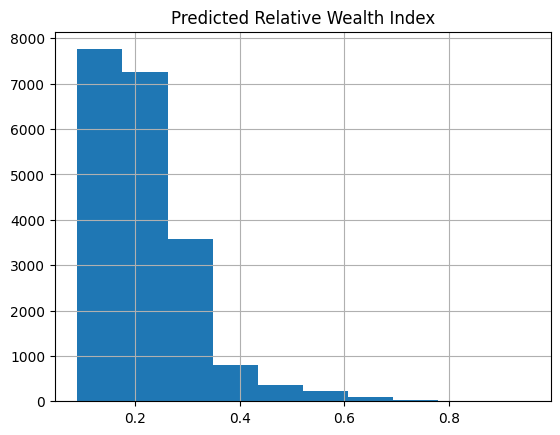

In [14]:
rollout_aoi[['Predicted Relative Wealth Index']].hist()

In [15]:
rollout_aoi.head()

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count,geometry,Predicted Relative Wealth Index,Predicted Wealth Category (quintile),...,mobile_2019_mean_avg_d_kbps_mean,mobile_2019_mean_avg_u_kbps_mean,mobile_2019_mean_avg_lat_ms_mean,mobile_2019_mean_num_tests_mean,mobile_2019_mean_num_devices_mean,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,13223001030111,Botum Sakor,None,KHM-ADM2-3_0_0-B77,KHM,ADM2,1.530576,"POLYGON ((103.16162 10.81172, 103.16162 10.833...",0.127308,E,...,0.0,0.0,0.0,0.0,0.0,-0.064363,0.013467,-0.025393,0.019338,-0.025305
1,13223001013222,Botum Sakor,None,KHM-ADM2-3_0_0-B77,KHM,ADM2,1.530576,"POLYGON ((103.18359 10.83331, 103.18359 10.854...",0.120062,E,...,0.0,0.0,0.0,0.0,0.0,-0.067641,0.010784,-0.029816,0.019521,-0.031274
2,13223001031000,Botum Sakor,None,KHM-ADM2-3_0_0-B77,KHM,ADM2,6.122304,"POLYGON ((103.18359 10.81172, 103.18359 10.833...",0.135268,E,...,0.0,0.0,0.0,0.0,0.0,-0.052187,0.015620,-0.017331,0.021790,-0.017005
3,13223001012210,Kiri Sakor,None,KHM-ADM2-3_0_0-B78,KHM,ADM2,8.403372,"POLYGON ((103.05176 10.89804, 103.05176 10.919...",0.169012,D,...,0.0,0.0,0.0,0.0,0.0,-0.006993,0.063116,0.020211,0.015892,0.017605
4,13223001012211,Kiri Sakor,None,KHM-ADM2-3_0_0-B78,KHM,ADM2,6.302529,"POLYGON ((103.07373 10.89804, 103.07373 10.919...",0.246007,B,...,0.0,0.0,0.0,0.0,0.0,-0.027030,0.075026,0.014192,0.026372,0.009149


### Static Map Viz

<Figure size 640x480 with 0 Axes>

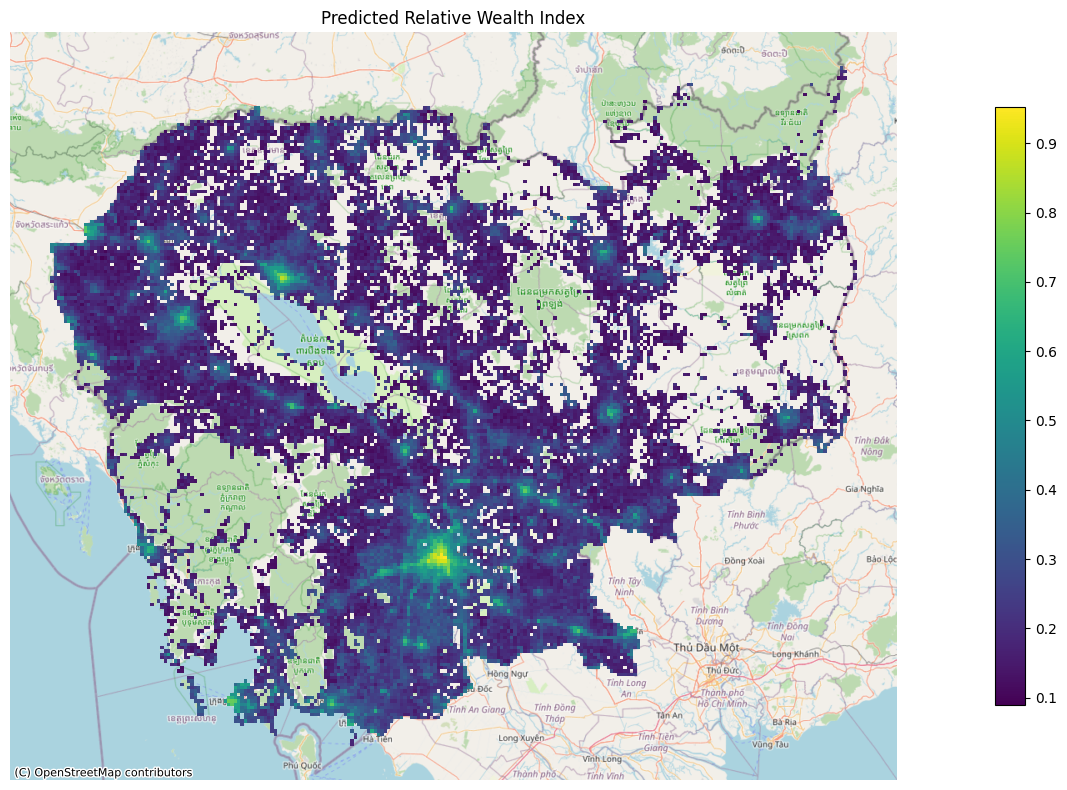

In [16]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot("Predicted Relative Wealth Index", figsize=(20, 8), cmap="viridis", legend=True, legend_kwds={'shrink': 0.8})
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Relative Wealth Index")
plt.tight_layout()
plt.savefig(f'{rollout_date}-{country_code}-predicted-wealth-index.png')
plt.show()

<Figure size 640x480 with 0 Axes>

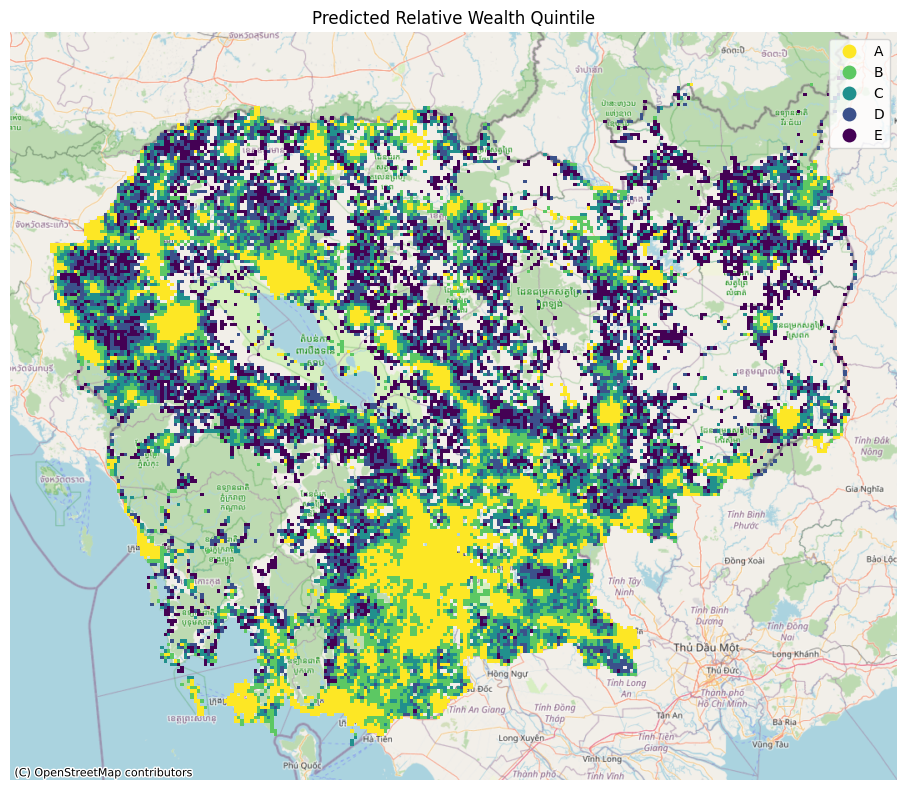

In [17]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot("Predicted Wealth Category (quintile)", figsize=(20, 8), cmap="viridis_r", legend=True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Relative Wealth Quintile")
plt.tight_layout()
plt.savefig(f'{rollout_date}-{country_code}-predicted-wealth-bin.png')
plt.show()

### Interactive Map Viz

In [18]:
cols_of_interest = [
    "quadkey",
    "shapeName",
    "shapeGroup",
    "pop_count",
    "avg_rad_mean",
    "mobile_2019_mean_avg_d_kbps_mean",
    "fixed_2019_mean_avg_d_kbps_mean",
    "poi_count",
    "road_count",
    "Predicted Relative Wealth Index",
    "Predicted Wealth Category (quintile)",
]

# Warning: This can be a bit laggy due to the large amount of tiles being visualized

# Uncomment the ff if you want to viz the raw wealth predictions
# rollout_aoi.explore(column='Predicted Relative Wealth Index', tooltip=cols_of_interest, cmap="viridis")

# Uncomment the ff if you want to view the quintiles
# rollout_aoi.explore(column='Predicted Wealth Category (quintile)', tooltip=cols_of_interest, cmap="viridis_r")